# Hierarchical Clustering

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def load_pca_matrix(path="Data/pca_dataset.csv", pc_prefix="PC"):
    df = pd.read_csv(path)
    pc_cols = [c for c in df.columns if c.startswith(pc_prefix)]
    X = df[pc_cols].to_numpy()
    return df, X, pc_cols

def hac_sweep_metrics(X, k_min=2, k_max=10, linkage="ward", affinity="euclidean"):
    sil, ch, db = {}, {}, {}
    for k in range(k_min, k_max+1):
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage, affinity=affinity)
        labels = model.fit_predict(X)
        sil[k] = silhouette_score(X, labels, metric="euclidean")
        ch[k]  = calinski_harabasz_score(X, labels)
        db[k]  = davies_bouldin_score(X, labels)
    return sil, ch, db

df_pca, Xpca, pc_cols = load_pca_matrix()
sil, ch, db = hac_sweep_metrics(Xpca, linkage="ward", affinity="euclidean")

# Choose k (primary = Silhouette; tie-break with CH↑ / DB↓)
k_star = max(sil, key=sil.get)
print("Silhouette by k:", sil, "\nCH by k:", ch, "\nDB by k:", db)
print("Chosen k:", k_star)


c:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
c:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in ver

Silhouette by k: {2: 0.3201937093456804, 3: 0.2926013462928688, 4: 0.21136254262431867, 5: 0.1275058848329148, 6: 0.11889497047933682, 7: 0.10790617275236183, 8: 0.10615806188664112, 9: 0.07796957460617021, 10: 0.07838021295623472} 
CH by k: {2: 2885.7945016640106, 3: 2726.4862739160653, 4: 2100.499478841912, 5: 1763.794952863, 6: 1521.31341855537, 7: 1339.1443416902612, 8: 1205.7145660165547, 9: 1091.4989420880013, 10: 1002.676444546111} 
DB by k: {2: 1.1045571425358394, 3: 1.5212342163037151, 4: 2.02300017154686, 5: 2.182671966895709, 6: 2.475969048325697, 7: 2.61226187711765, 8: 2.606307196298573, 9: 2.5938012819393608, 10: 2.5594122873140552}
Chosen k: 2


In [2]:

final = AgglomerativeClustering(n_clusters=k_star, linkage="ward", affinity="euclidean")
df_pca["cluster_hac"] = final.fit_predict(Xpca)


c:\Users\navee\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


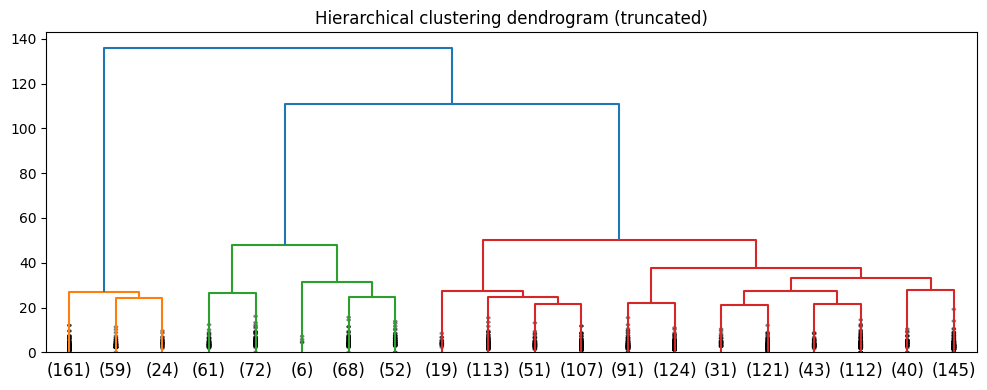

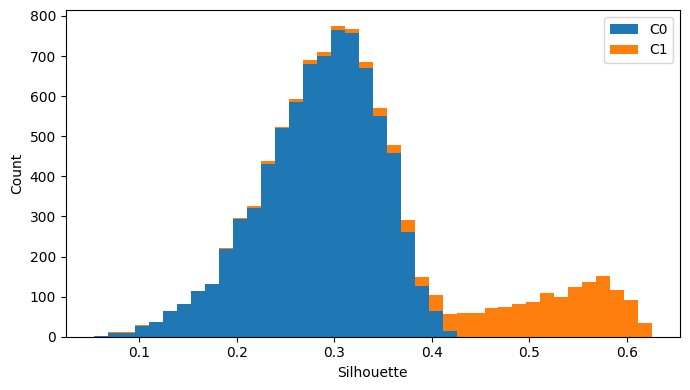

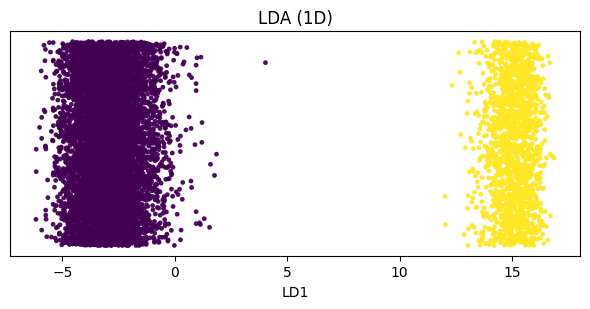

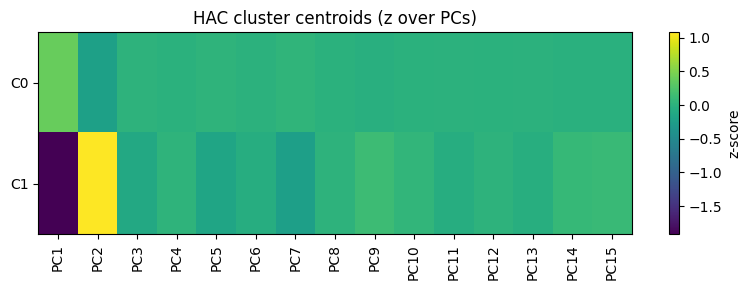

In [3]:
# Dendrogram (scipy) — sample to keep it fast
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
rng = np.random.default_rng(47)
idx = rng.choice(len(Xpca), size=min(1500, len(Xpca)), replace=False)  
Z = linkage(Xpca[idx], method="ward", metric="euclidean")
plt.figure(figsize=(10,4))
dendrogram(Z, truncate_mode="lastp", p=20, show_contracted=True)
plt.title("Hierarchical clustering dendrogram (truncated)"); plt.tight_layout(); plt.show()

# Per-sample silhouette for HAC labels
from sklearn.metrics import silhouette_samples
import numpy as np
labels = df_pca["cluster_hac"].to_numpy()
svals = silhouette_samples(Xpca, labels, metric="euclidean")
plt.figure(figsize=(7,4))
for k in np.unique(labels):
    vals = np.sort(svals[labels==k])
    y0 = sum((labels<k).sum() for k in [])  # placeholder to avoid confusion—simple stacked plot:
plt.hist([svals[labels==k] for k in np.unique(labels)], bins=40, stacked=True, label=[f"C{k}" for k in np.unique(labels)])
plt.xlabel("Silhouette"); plt.ylabel("Count"); plt.legend(); plt.tight_layout(); plt.show()

# LDA projection (great for 2D separability)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
n_comp = min(2, len(np.unique(labels))-1)
if n_comp >= 1:
    X_lda = LDA(n_components=n_comp).fit_transform(Xpca, labels)
    if n_comp==2:
        plt.figure(figsize=(6,5))
        plt.scatter(X_lda[:,0], X_lda[:,1], s=6, c=labels, alpha=0.9)
        plt.title("LDA of HAC clusters"); plt.xlabel("LD1"); plt.ylabel("LD2"); plt.tight_layout(); plt.show()
    else:
        plt.figure(figsize=(6,3.2))
        jitter = (np.random.rand(len(X_lda))-0.5)*0.02
        plt.scatter(X_lda[:,0], jitter, s=6, c=labels, alpha=0.9)
        plt.title("LDA (1D)"); plt.xlabel("LD1"); plt.yticks([]); plt.tight_layout(); plt.show()

# Cluster centroid heatmap (z-scores across PCs)
Xpca_z = (Xpca - Xpca.mean(axis=0)) / (Xpca.std(axis=0)+1e-9)
centroids = pd.DataFrame(Xpca_z).groupby(labels).mean()
plt.figure(figsize=(8, 0.5*len(centroids)+2))
plt.imshow(centroids, aspect="auto")
plt.colorbar(label="z-score")
plt.yticks(range(len(centroids)), [f"C{k}" for k in centroids.index])
plt.xticks(range(len(pc_cols)), pc_cols, rotation=90)
plt.title("HAC cluster centroids (z over PCs)"); plt.tight_layout(); plt.show()


# Subclustering

In [4]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# --- helpers ---
def pca_matrix(df, pc_prefix="PC"):
    pc_cols = [c for c in df.columns if c.startswith(pc_prefix)]
    X = df[pc_cols].to_numpy()
    return X, pc_cols

def best_k_on_subset(Xsub, k_candidates=(2,3,4), linkage="ward"):
    # filter infeasible k (must be < n_samples)
    n = len(Xsub)
    ks = [k for k in k_candidates if 2 <= k <= max(2, n-1)]
    scores = {"sil":{}, "ch":{}, "db":{}}
    for k in ks:
        lab = AgglomerativeClustering(n_clusters=k, linkage=linkage).fit_predict(Xsub)
        scores["sil"][k] = silhouette_score(Xsub, lab)
        scores["ch"][k]  = calinski_harabasz_score(Xsub, lab)
        scores["db"][k]  = davies_bouldin_score(Xsub, lab)
    # choose by sil, tie-break CH↑ then DB↓
    k_star = max(ks, key=lambda k: (scores["sil"][k], scores["ch"][k], -scores["db"][k]))
    return k_star, scores

def two_stage_hac_refine(
    df_pca: pd.DataFrame,
    parent_col: str = "cluster_hac",   # your k=2 labels here
    pc_prefix: str = "PC",
    k_candidates_per_parent: dict | None = None,  # e.g., {0:(2,), 1:(3,)} to force 2 & 3
    linkage: str = "ward",
):
    """
    Returns df_out with final numeric labels 0..K-1 and a 'details' dict.
    If k_candidates_per_parent is None, defaults to (2,3,4) for both parents.
    """
    X, _ = pca_matrix(df_pca, pc_prefix)
    parents = df_pca[parent_col].to_numpy()
    uniq = np.unique(parents)
    assert len(uniq) == 2, "parent_col must contain exactly 2 top-level clusters"

    final_labels = np.empty(len(df_pca), dtype=int)
    next_id = 0
    details = {}

    for p in sorted(uniq):
        idx = np.where(parents == p)[0]
        Xsub = X[idx]
        k_cands = (k_candidates_per_parent.get(int(p), (2,3,4))
                   if k_candidates_per_parent is not None else (2,3,4))

        k_star, scores = best_k_on_subset(Xsub, k_candidates=k_cands, linkage=linkage)
        sub = AgglomerativeClustering(n_clusters=k_star, linkage=linkage).fit_predict(Xsub)

        # remap local 0..k_star-1 to global next_id..next_id+k_star-1
        uniq_sub = np.unique(sub)
        remap = {loc: next_id + i for i, loc in enumerate(sorted(uniq_sub))}
        final_labels[idx] = [remap[s] for s in sub]

        details[int(p)] = {
            "n": len(idx),
            "k_star": int(k_star),
            "k_candidates": list(k_cands),
            "counts_local": pd.Series(sub).value_counts().to_dict(),
            "scores": scores,
            "global_ids": {int(k): int(v) for k, v in remap.items()},
        }
        next_id += k_star

    df_out = df_pca.copy()
    df_out["cluster_refined_num"] = final_labels  # 0..K-1 across both branches
    return df_out, details


In [5]:
df_final, info = two_stage_hac_refine(df_pca, parent_col="cluster_hac")
print(df_final["cluster_refined_num"].value_counts().sort_index())
print({p: d["k_star"] for p,d in info.items()})  

cluster_refined_num
0    1762
1    6131
2    1374
3     175
Name: count, dtype: int64
{0: 2, 1: 2}


In [6]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- Core utilities ---
def _pca_matrix(df, pc_prefix="PC"):
    pc_cols = [c for c in df.columns if c.startswith(pc_prefix)]
    X = df[pc_cols].to_numpy()
    return X, pc_cols

def _best_k_on_subset(Xsub, k_candidates=(2,3,4), linkage="ward"):
    ks = [k for k in k_candidates if 2 <= k <= max(2, len(Xsub)-1)]
    sil, ch, db = {}, {}, {}
    for k in ks:
        lab = AgglomerativeClustering(n_clusters=k, linkage=linkage).fit_predict(Xsub)
        sil[k] = silhouette_score(Xsub, lab)
        ch[k]  = calinski_harabasz_score(Xsub, lab)
        db[k]  = davies_bouldin_score(Xsub, lab)
    k_star = max(ks, key=lambda k: (sil[k], ch[k], -db[k]))
    return k_star, {"sil": sil, "ch": ch, "db": db}

# --- Final visuals over all clusters ---
def _plot_cluster_sizes(labels):
    counts = Counter(labels)
    labs, vals = zip(*sorted(counts.items()))
    plt.figure(figsize=(6,3.5))
    plt.bar([str(x) for x in labs], vals)
    plt.title("Final cluster sizes"); plt.xlabel("Cluster"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

def _plot_silhouette_histogram(X, labels):
    svals = silhouette_samples(X, labels)
    uniq = sorted(np.unique(labels))
    plt.figure(figsize=(7,4))
    plt.hist([svals[labels==u] for u in uniq], bins=40, stacked=True, label=[f"C{u}" for u in uniq])
    plt.xlabel("Silhouette"); plt.ylabel("Count"); plt.legend(); plt.tight_layout(); plt.show()

def _plot_lda(X, labels, title="LDA of final clusters"):
    uniq = np.unique(labels)
    n_comp = min(2, len(uniq)-1)
    if n_comp < 1: return
    Z = LDA(n_components=n_comp).fit_transform(X, labels)
    if n_comp == 2:
        plt.figure(figsize=(6,5))
        plt.scatter(Z[:,0], Z[:,1], s=6, c=labels, alpha=0.9)
        plt.xlabel("LD1"); plt.ylabel("LD2"); plt.title(title)
        plt.tight_layout(); plt.show()
    else:
        plt.figure(figsize=(6,3.2))
        jitter = (np.random.rand(len(Z))-0.5)*0.02
        plt.scatter(Z[:,0], jitter, s=6, c=labels, alpha=0.9)
        plt.xlabel("LD1"); plt.yticks([]); plt.title(title)
        plt.tight_layout(); plt.show()

def _plot_centroid_heatmap(X, labels, pc_cols):
    Xz = (X - X.mean(axis=0)) / (X.std(axis=0)+1e-9)
    cent = pd.DataFrame(Xz, columns=pc_cols).assign(cluster=labels).groupby("cluster").mean()
    plt.figure(figsize=(8, 0.5*len(cent)+2))
    plt.imshow(cent.values, aspect="auto")
    plt.colorbar(label="z-score")
    plt.yticks(range(len(cent)), [f"C{c}" for c in cent.index])
    plt.xticks(range(len(pc_cols)), pc_cols, rotation=90)
    plt.title("Cluster centroids (z over PCs)")
    plt.tight_layout(); plt.show()

# --- Subcluster specific labels and recombine ---
def subcluster_specific_labels(
    df_pca: pd.DataFrame,
    label_col: str = "cluster_refined_num",   # current global labels (ints)
    targets=(1,),                             # which clusters to split further
    k_candidates=(2,3),                       # try 2 or 3; set (3,) to force 3
    linkage="ward",
    pc_prefix="PC",
    visualize=True
):
    X, pc_cols = _pca_matrix(df_pca, pc_prefix)
    labels = df_pca[label_col].to_numpy().copy().astype(int)
    next_id = int(labels.max()) + 1
    details = {}

    for t in targets:
        idx = np.where(labels == t)[0]
        if len(idx) < max(k_candidates):
            details[t] = {"skipped": True, "reason": f"cluster size {len(idx)} < max(k_candidates)"}
            continue
        Xsub = X[idx]
        k_star, scores = _best_k_on_subset(Xsub, k_candidates=k_candidates, linkage=linkage)
        sub = AgglomerativeClustering(n_clusters=k_star, linkage=linkage).fit_predict(Xsub)

        # remap local → new global ids; free original id 't'
        uniq_local = sorted(np.unique(sub))
        remap = {loc: next_id+i for i, loc in enumerate(uniq_local)}
        labels[idx] = np.vectorize(remap.get)(sub)
        details[t] = {"n": len(idx), "k_star": int(k_star), "scores": scores, "new_ids": remap}
        next_id += k_star

    df_out = df_pca.copy()
    df_out[label_col] = labels

    if visualize:
        _plot_cluster_sizes(labels)
        _plot_silhouette_histogram(X, labels)
        _plot_lda(X, labels, title="LDA — final clusters")
        _plot_centroid_heatmap(X, labels, pc_cols)

    return df_out, details


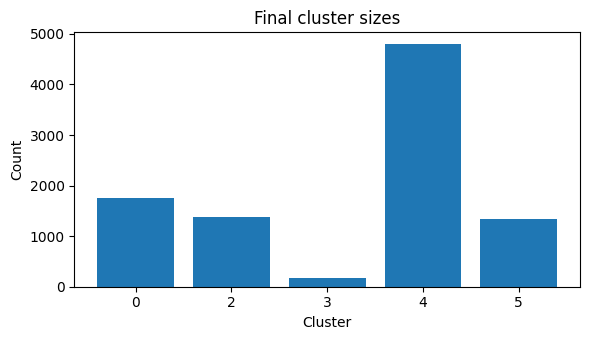

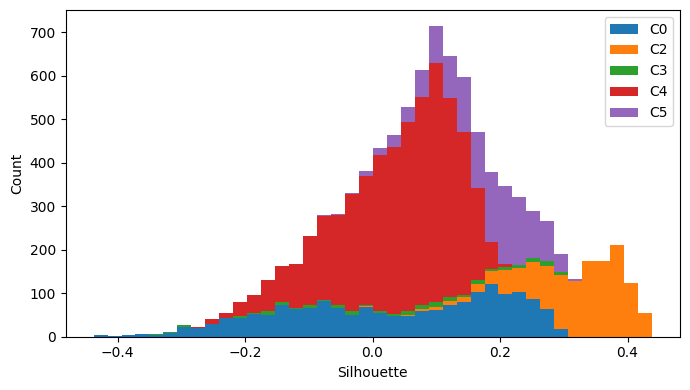

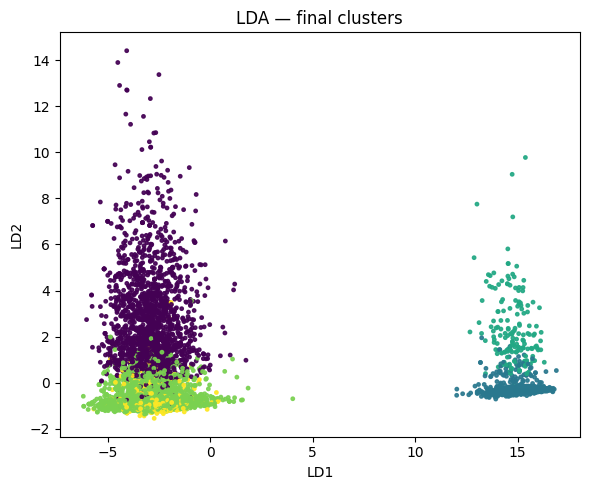

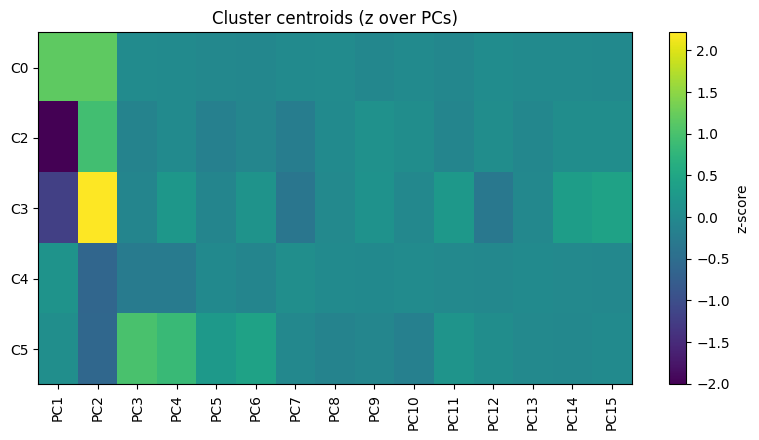

{1: {'n': 6131,
  'k_star': 2,
  'scores': {'sil': {2: 0.06772072160283252,
    3: 0.05717316845667309,
    4: 0.0448202707987875},
   'ch': {2: 481.2227118515777, 3: 425.76997320397084, 4: 383.53566148997044},
   'db': {2: 2.6967185827304343, 3: 3.129434103382921, 4: 3.219418287928629}},
  'new_ids': {0: 4, 1: 5}}}

In [7]:
df_final2, info2 = subcluster_specific_labels(
    df_final,                 
    label_col="cluster_refined_num",
    targets=(1,),             # split cluster 1 only
    k_candidates=(2,3, 4),       
    linkage="ward",
    pc_prefix="PC",
    visualize=True
)

df_final2["cluster_refined_num"].value_counts().sort_index()
info2
